# TKT4108 Structural Dynamics 2

## Solution exercise 5

**Main topics:** Spectral density, frequency response method, spectral density of dynamic response

**References:** Newland Chapter 4-5, 6-7




### Problem 1: Frequency response method

**a)** 

This is a rectangular spectrum (approximating white noise). We can simulate using the IFFT-method.


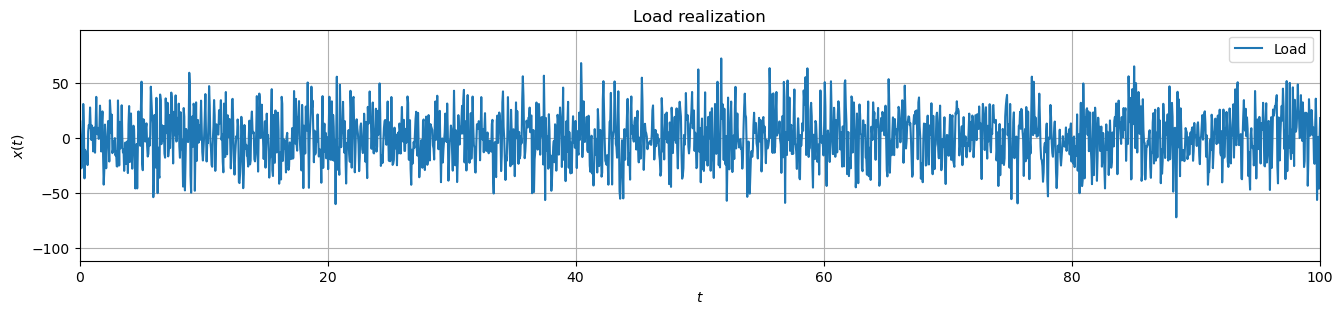

In [58]:
import numpy as np
from matplotlib import pyplot as plt
import time

T=600 # Simulation length
dt=0.05 # Time step

N=int(T/dt)
t = np.arange(0,N,1)*dt # Time axis
domega=2*np.pi/T # Frequency spacing
omega_axis = np.arange(0,N,1)*domega # Frequency axis

S=np.zeros_like(omega_axis)
S[(omega_axis>0) & (omega_axis<50)]=10

phi = np.random.rand(N)*2*np.pi # Random phase angles 

c_amp = (2*S*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c_amp)*N) # The IFFT

# Plot
plt.figure(figsize=(16,3))
plt.plot(t,x,label='Load')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.title('Load realization')
plt.xlim(0,T)
plt.xlim(0,100)
plt.grid()
plt.legend()


**b)**

To derive the frequency response method, we assume that the load is harmonic with unit amplitude $x(t) = e^{i\omega t}$. We further assume that the particular solution takes the form $y=H(\omega)e^{i \omega t}$

Inserting the particular solution into the equation of motion renders:

$$ \left(-\omega^2 m + i \omega c  + k\right)H(\omega)e^{i\omega t} = e^{i\omega t} $$

The frequency response function of the system is:

$$ H(\omega) = \frac{1}{\left(-\omega^2 m + i \omega c  + k\right)} $$

The frequency response method can be summarized in the following manner.

1) Take the Fourier transform of the load (approximate by using a Fourier series)
    
2) Multiply the Fourier transform of the load with the frequency response function to get the Fourier transform of the response

3) Obtain the response by taking the inverse Fourier transform of the Fourier transform of the response

It is important to remember that following the above procedure assumes that the loading is periodic. It is, therefore, necessary to ensure that the load is zero for a sufficiently long time at the end of the time series to ensure that the response has time to settle to zero. Any remaining response at the end of the calculated time series will be introduced as initial conditions and will, therefore, reduce the accuracy of the solution significantly. 


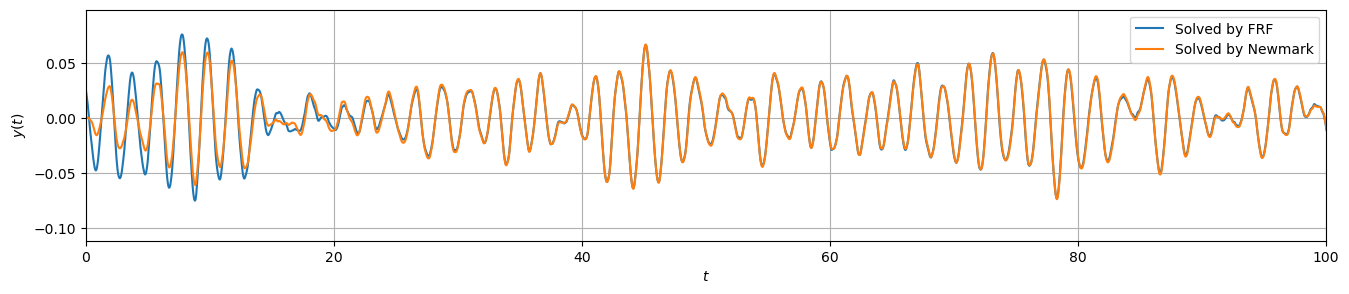

In [59]:
import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

# Load in the frequency domain
x_fft = np.fft.fft(x)/N # DFT
f_fft = np.fft.fftfreq(N, d=dt) # Frequency axis in Hz

omega_fft=2*np.pi*f_fft

# Frequency response function
H=1/(-omega_fft**2*m+1j*omega_fft*c+k)

# Response in the frequency domain
y_fft=H*x_fft

# Response in the time domain
y_fd= np.fft.ifft(y_fft)*N # IDFT

# Solve also by Newmarks method for extra verification
y_newmark, ydot, y2dot = linear_newmark_krenk(m,c,k,x,u0,udot0,dt)

# Plot
plt.figure(figsize=(16,3))
plt.plot(t,y_fd,label='Solved by FRF')
plt.plot(t,y_newmark[0,:],label='Solved by Newmark')
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.xlim(0,100)
plt.grid()
plt.legend()

The responses are similar, as expected. Small differences can be observed in the beginning:
- Newmarks's method has initial conditions zero ($u=0$, defined by us)
- The initial conditions in the FFT-based method is implicitly defined by load at the end of the 


### Problem 2: Stochastic response in a single degree of freedom system

**a)**

Text(0.5, 0, '$\\omega$')

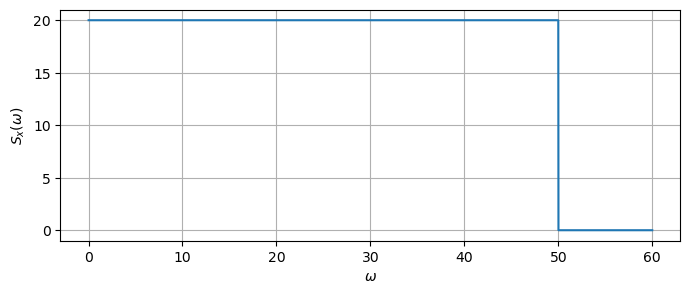

In [60]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

omega_axis = np.arange(0.01,60,0.01) # Frequency axis

Sx=np.zeros_like(omega_axis)
Sx[(omega_axis>0) & (omega_axis<50)]=20

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sx)
plt.grid()
plt.ylabel(r'$S_x(\omega)$')
plt.xlabel(r'$\omega$')
#plt.yscale('log')

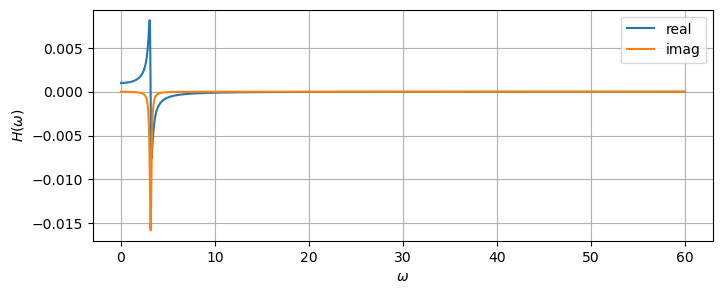

In [61]:
# Structural parameters
m=100
k=1000
c=20

# FRF
H=1/(-omega_axis**2*m+1j*omega_axis*c+k)

plt.figure(figsize=(8,3))
plt.plot(omega_axis,np.real(H),'-',label='real')
plt.plot(omega_axis,np.imag(H),'-',label='imag')
plt.grid()
plt.ylabel(r'$H(\omega)$')
plt.xlabel(r'$\omega$')
plt.legend()

Text(0.5, 0, '$\\omega$')

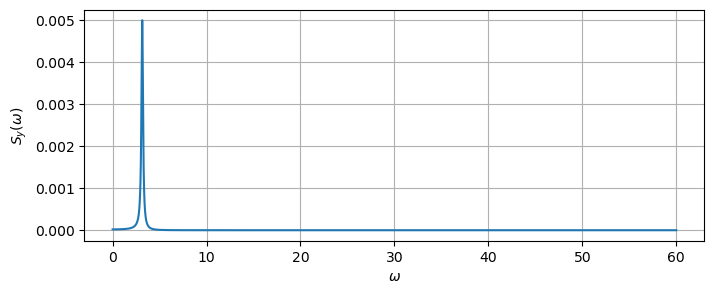

In [62]:
Sy=np.abs(H)**2*Sx

sd_y_fd=np.trapezoid(Sy,omega_axis)**0.5 # Standard deviation needed later

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sy)
plt.grid()
plt.ylabel(r'$S_y(\omega)$')
plt.xlabel(r'$\omega$')
#plt.yscale('log')

**b)**

The natural frequency is $\sqrt{k/m}=\sqrt{10}=3.16$ rad/s, which has a natural period of 2 s. We set $\Delta t=0.02$ s.


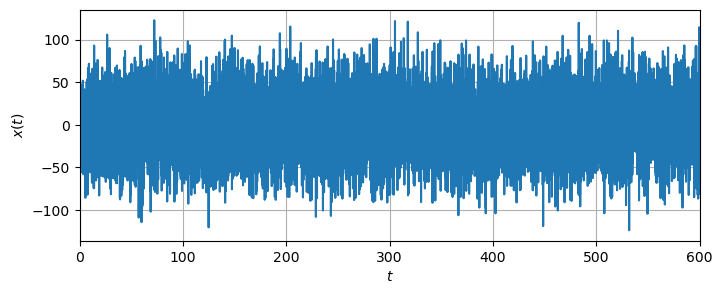

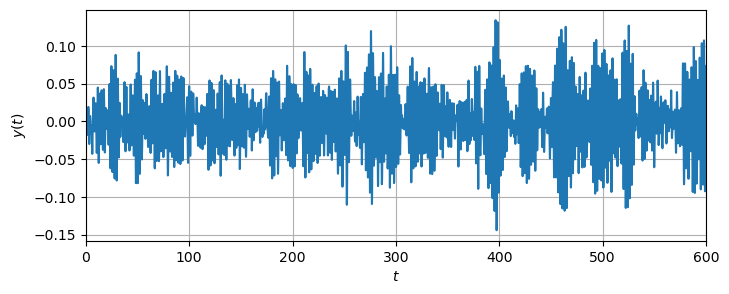

In [63]:

T=600
dt=0.02

N=int(T/dt)
t=np.arange(0,N,1)*dt # Time axis
domega=2*np.pi/T # Frequency spacing
omega_axis = np.arange(0,N,1)*domega # Frequency axis

Sx=np.zeros_like(omega_axis)
Sx[(omega_axis>0) & (omega_axis<50)]=20
Sx[0]=0

phi = np.random.rand(N)*2*np.pi # Random phase angles 
c_amp = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c_amp)*N) # The IFFT

# Plot time series load
plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,600)
plt.grid()

y0 = np.array([0.0]) #Initial displacement
ydot0 = np.array([0.0]) # Initial velocity

# Solve by Newmark
y, ydot, y2dot = linear_newmark_krenk(m,c,k,x,y0,ydot0,dt)

# Plot time series response
plt.figure(figsize=(8,3))
plt.plot(t,y[0,:])
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,600)
plt.grid()

**c)**

In [64]:
sd_y_td=np.std(y[0,:])

print('Standard deviation of y is (time domain) ' + '{:.3e}'.format(sd_y_td))
print('Standard deviation of y is (frequency domain) ''{:.3e}'.format(sd_y_fd))

Standard deviation of y is (time domain) 3.933e-02
Standard deviation of y is (frequency domain) 3.963e-02


The standard deviation is the same, as expected. This means the variance can be directly calculated in the frequency domain as the area under the spectrum, and it is not neccessary to generate simulations of the load and then solve the response in order to obtain the response statistics.

### Problem 3: Spectral density of response in modal coordinates

**a)**

The stiffness matrix $\mathbf{K}$ can be obtained by sequentially setting each DOF to a unity value, and then considering the forces in each DOF: 

$$
\mathbf{K}  = \begin{bmatrix}
2k_1 + 2k_2 & -2k_2 & 0 \\
-2k_2 & 2k_2 + 2k_3 & -2k_3 \\
0 & -2k_3 & 2k_3
\end{bmatrix}
$$

The mass matrix is diagonal since the floor masses are lumped into each DOF:

$$
\mathbf{M}  = \text{diag}(m_1, m_2, m_3)
$$

We start by calculating the modal properties.

In [65]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as spla

# Define structural properties
m1=5.0
m2=4.0
m3=4.0

k1=1.5e3
k2=1.0e3
k3=1.0e3

K = np.array(([[2*k1+2*k2, -2*k2,0],
                [-2*k2, 2*k2+2*k3,-2*k3],
                [0, -2*k3,2*k3]])) # Stiffness matrix

M = np.diag([m1,m2,m3]) # Mass matrix
lam,v = spla.eig(K,M) #Solve eigenvalue problem using scipy 

mgen=v.T @ M @ v # Generalized masses (before normalization)

Phi=np.zeros_like(v)
for k in np.arange(3):
    Phi[:,k]=v[:,k]/np.sqrt(mgen[k,k]) # Mass normalize eigenvectors

omega_n = np.real(lam)**0.5 #Natural frequencies in rad/s

idx_sort=np.argsort(omega_n) # Find sorting order (smallest to biggest frequency)

omega_n=omega_n[idx_sort] # Rearrange frequencies
Phi=Phi[:,idx_sort] # Rearrange modes

print('Natural frequencies in rad/s:')
print(omega_n)

print('Mode shapes:')
print(Phi)

Natural frequencies in rad/s:
[10.87504704 28.35085542 39.72357422]
Mode shapes:
[[ 0.13155433  0.34157989  0.25693703]
 [ 0.2899896   0.1675697  -0.37124982]
 [ 0.37983267 -0.27581582  0.17219981]]


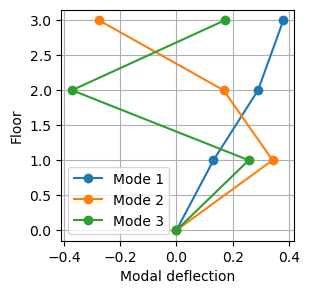

In [66]:
plt.figure(figsize=(3,3))

# Plot all 3 modes
for i in np.arange(3):

    phi_plot=np.append(0,Phi[:,i]) # Add zero to base of structure
    plt.plot(phi_plot,[0,1,2,3],marker='o',label='Mode ' + str(i+1))

plt.ylabel('Floor')
plt.xlabel('Modal deflection')
plt.legend()
plt.grid()


**b)**

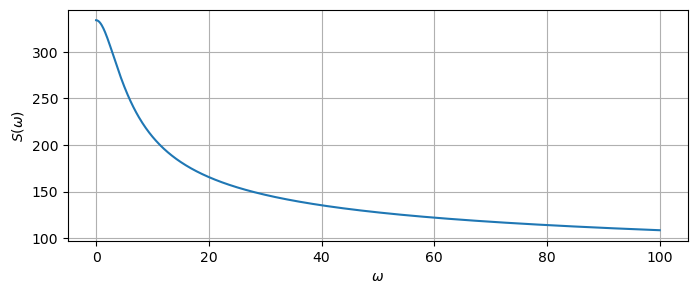

In [67]:
omega_axis=np.linspace(0,100,1000)

Sx=np.zeros((3,3,len(omega_axis)))
for k in np.arange(3):
    Sx[k,k,:]=1e3/np.log(omega_axis**2+20)
Sx[:,:,0]=0

plt.figure(figsize=(8,3))
plt.plot(omega_axis,1e3/np.log(omega_axis**2+20))
plt.grid()
plt.ylabel(r'$S(\omega)$')
plt.xlabel(r'$\omega$')

Sx_modal=np.zeros((3,3,len(omega_axis)))
for k in np.arange(len(omega_axis)):
    Sx_modal[:,:,k]=Phi.T @ Sx[:,:,k] @ Phi


From this plot, we can expect all modes to be excited (natural frequencies are 10.8, 28.3, and 39.7 rad/s), but the lower modes will probably have the largest contribution since there is more energy in the lower frequency range.

**c)**

The modal load is given by $\mathbf{\tilde{x}}(t) = \mathbf{\Phi}^\text{T} \mathbf{x}(t) $.

Therefore, the spectrum of the modal load is: 

$$
\mathbf{S}_\mathbf{\tilde{x}}(\omega)=\mathbf{\Phi}^\text{T}
\mathbf{S}_\mathbf{x}(\omega)
\mathbf{\Phi}
$$

See the posted examples for a derivation. The equation of motion is:
$$
\mathbf{M} \mathbf{\ddot{y}}(t)+\mathbf{C} \mathbf{\dot{z}}(t)+ \mathbf{K}  \mathbf{y}(t)= \mathbf{{x}}(t)
$$

After introducing $\mathbf{y}(t)= \mathbf{\Phi} \mathbf{z}(t) $ and premultiplying by $\mathbf{\Phi}^\text{T}$ we get:

$$
\mathbf{\ddot{z}}(t)+2  \cdot  \textbf{diag} (\xi)  \cdot  \textbf{diag} (\omega_n)  \cdot \mathbf{\dot{z}}(t)+ \textbf{diag} (\omega_n^2) \mathbf{z}(t)= \mathbf{\tilde{x}}(t)
$$

Here, the mode shapes are assumed to be mass-normalized.

**d)**

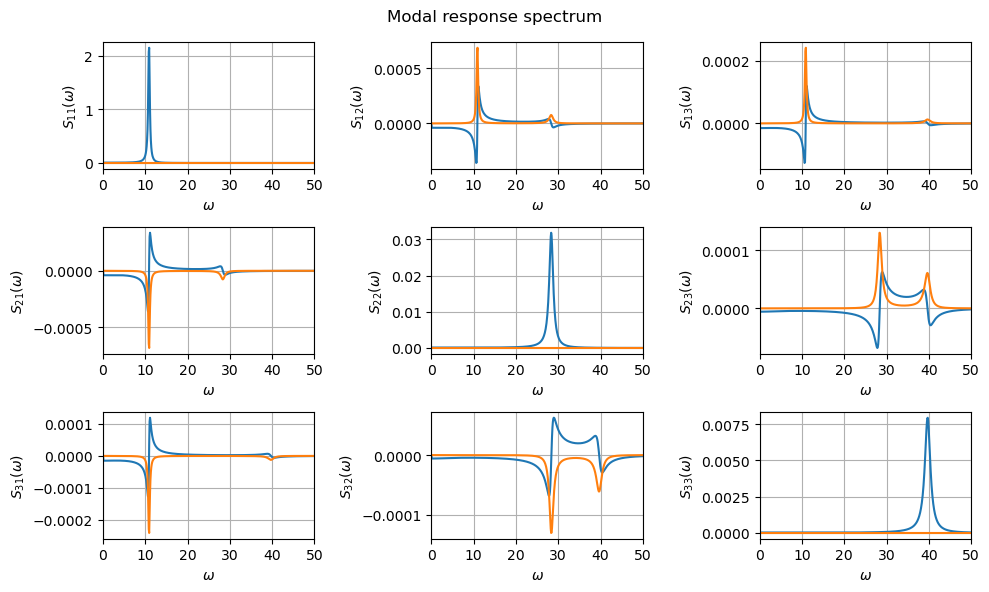

In [68]:
# Calculate FRF
H_modal=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    H_modal[:,:,k]=np.linalg.inv(-omega_axis[k]**2*np.eye(3)+1j*omega_axis[k]*2*np.diag(omega_n)*0.02+np.diag(omega_n)**2)

# Calculate modal response PSD
Sz=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sz[:,:,k]=H_modal[:,:,k] @ Sx_modal[:,:,k] @ np.conj(H_modal[:,:,k]).T

# Plot
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,np.real(Sz[i,j,:]))
        axs[i,j].plot(omega_axis,np.imag(Sz[i,j,:]))        
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)
        
fig.suptitle('Modal response spectrum')
plt.tight_layout()

The auto spectra only have one peak, at their respective natural frequencies. The cross-spectra between the modes have some small correlations.

**e)**

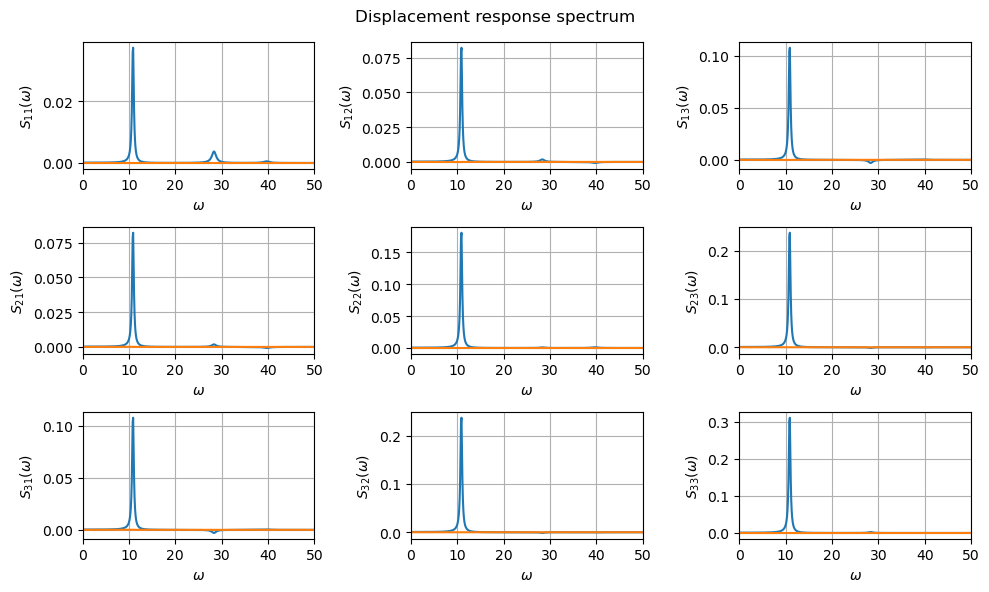

In [69]:
Sy=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sy[:,:,k]=Phi @ Sz[:,:,k] @ Phi.T

# Plot
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,np.real(Sy[i,j,:]))
        axs[i,j].plot(omega_axis,np.imag(Sy[i,j,:]))
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)
        
fig.suptitle('Displacement response spectrum')
plt.tight_layout()


The auto spectra now have multiple peaks, although mode 1 is the dominant contributor. Small contributions from mode 2 and 3 are visible for $y_1$.

**f)**

We can first calculate the covariance matrix for $\mathbf{y}$:

$$\mathbf{\Sigma_y}^2 = \left[ \begin{array}{c c c}
{\sigma _{y_1}^2}&{\rho _{y_1y_2}\sigma _{y_1}\sigma _{y_2}}& {\rho _{y_1y_3}\sigma _{y_1}\sigma _{y_3}}\\
{\rho _{y_2y_1}\sigma _{y_2}\sigma _{y_1}}&{\sigma _{y_2}^2}&{\rho _{y_2y_3}\sigma _{y_2}\sigma _{y_3}} \\
{\rho _{y_3y_1}\sigma _{y_3}\sigma _{y_1}}&{\rho _{y_3y_2}\sigma _{y_3} \sigma _{y_2}} & {\sigma _{y_2}^3}\\
\end{array} \right] $$

We find this as the area under the spectrum:

$$
\mathbf{\Sigma_y}^2
=
\int_{-\infty}^{\infty} 
\mathbf{S}_\mathbf{y}(\omega) \: \text{d} \omega
$$

Since we have a one-sided cross-spectral density matrix, the imaginary component of the cross-spectra will not cancel out. We therefore have to remember to take the real part only.

We can then find the correlation coefficients as:
$$
\rho_{y_i y_j} = \dfrac{\text{Cov}(y_i,y_j)}{ \sigma _{y_i} \sigma _{y_j}}
$$




In [74]:
Cy=np.real(np.trapezoid(Sy,omega_axis,axis=2))

print('Covariance matrix:')
print(Cy)

print('Standard deviations:')
print(np.sqrt(np.diag(Cy)))



rho_y=np.zeros_like(Cy)
for i in np.arange(3):
    for j in np.arange(3):
        rho_y[i,j]=Cy[i,j]/( np.sqrt(Cy[i,i]) * np.sqrt(Cy[j,j]) )

print('Correlation matrix:')
print(rho_y)

Covariance matrix:
[[0.03458049 0.05998453 0.07225531]
 [0.05998453 0.13362157 0.16534341]
 [0.07225531 0.16534341 0.22671637]]
Standard deviations:
[0.18595831 0.36554284 0.47614742]
Correlation matrix:
[[1.         0.88244043 0.8160425 ]
 [0.88244043 1.         0.94996407]
 [0.8160425  0.94996407 1.        ]]


The correlations are quite high (>0.8). If only one mode contributed to the response, the correlation would be 1 or -1 since all floors are moving perfectly in phase or out of phase with each other. Since there are small response contributions from 2 and 3 as well, the correlation becomes a bit lower.

**g)**

We can repeat the same calculation with a truncated version of $\mathbf{\Phi}$. Instead of using

$$
\underbrace{\mathbf{\Phi}}_{3 \times 3}=
\begin{bmatrix}
\vdots & \vdots & \vdots \\
\phi_1 & \phi_2 & \phi_3 \\
\vdots & \vdots & \vdots
\end{bmatrix}
$$

we use

$$
\underbrace{\mathbf{\Phi}}_{3 \times 1}=
\begin{bmatrix}
\vdots \\
\phi_1  \\
\vdots 
\end{bmatrix}
$$

We simply slice out the first mode (index 0) from $\mathbf{S}_\mathbf{z}$ and the first column of $\mathbf{\Phi}$.






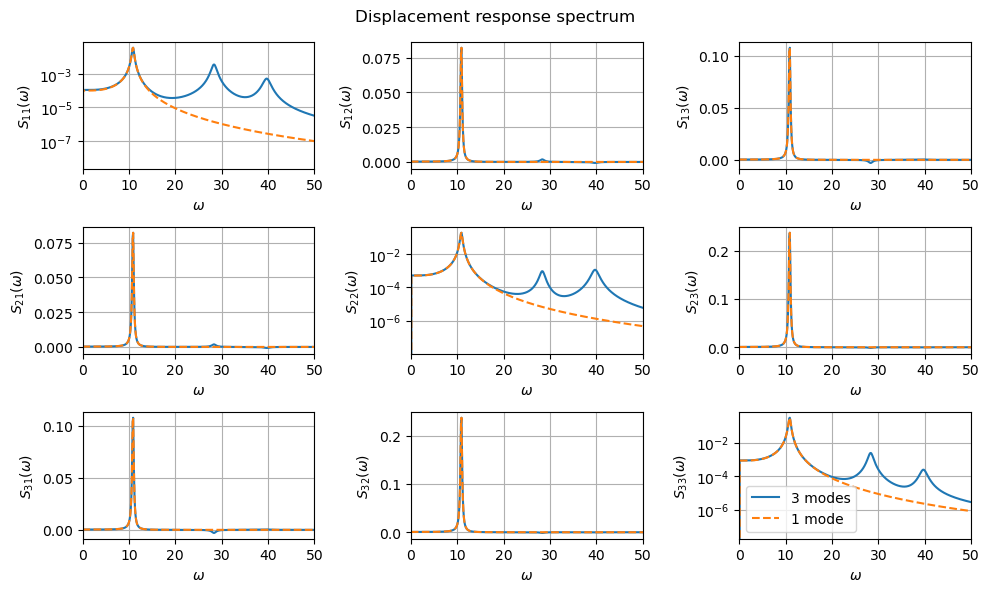

In [71]:
Sy_reduced=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):

    Phi_mode1=Phi[:, 0].reshape(-1, 1) # Ensure a column vector (Python will make the slice a 1d-vector)
    
    Sy_reduced[:,:,k]= Sz[0,0,k]*Phi_mode1@Phi_mode1.T

# Plot and compare with full
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,Sy[i,j,:],label='3 modes')
        axs[i,j].plot(omega_axis,Sy_reduced[i,j,:],'--',label='1 mode')
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)

        if i==j:
            axs[i,j].set_yscale('log')

fig.suptitle('Displacement response spectrum')
plt.tight_layout()
plt.legend()

We see that the calculation with one mode accounts for the first peak (and most of the variance of the spectrum), but it obviously neglects mode 2 and 3 (which are visible in log-scale).

A single-mode truncation of the system dynamics is a decent approximation in terms of variance (i.e., the area under the auto spectra).

**h)**

The acceleration response spectrum is derived from the displacement spectrum using the following relationship:

$$
\mathbf{S}_\mathbf{\ddot{y}}(\omega) = \omega^4 \mathbf{S}_\mathbf{y}(\omega)
$$

From the plot below, it is obvious that mode 2 and 3 contribute significantly to the accelerations, and a single mode truncation of the system dynamics is not a valid approximation.



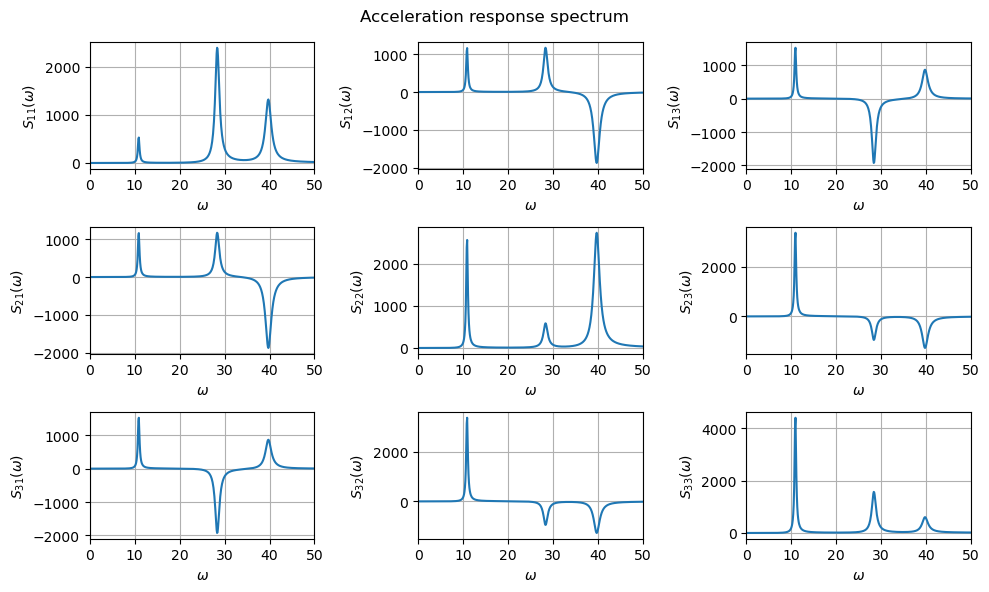

In [72]:

Syddot=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Syddot[:,:,k]=omega_axis[k]**4 * Sy[:,:,k]

# Plot and compare with full
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,Syddot[i,j,:])
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)

        #if i==j:
            #axs[i,j].set_yscale('log')

fig.suptitle('Acceleration response spectrum')
plt.tight_layout()


### Problem 4: Theory

**a)**

*i)*

We have the definition of the auto correlation of displacement: 

$$R_y(\tau)= \mathbb{E} [y(t) y(t + \tau)] $$

We start by differentiating once:

$$
\frac{\text{d} R_y(\tau)}{\text{d} \tau} 
= \mathbb{E} \left[ y(t) \frac{\text{d} y(t + \tau)}{\text{d} \tau} \right]
= \mathbb{E} \left[ y(t) \frac{\text{d} y(t + \tau)}{\text{d} (t+\tau)}\frac{\text{d} (t + \tau)}{\text{d} \tau} \right]
= \mathbb{E} \left[ y(t) \dot{y}(t + \tau) \right]
$$

In the last term, we now have the cross-correlation between the displacement and velocity. In general, if we take the reverse cross-correlation, the function is mirrored: $ R_{x_2 x_1}(\tau)=R_{x_1 x_2}(-\tau)$. We can therefore say:

$$
\mathbb{E} \left[ y(t) \dot{y}(t + \tau) \right]
=
\mathbb{E} \left[ \dot{y}(t) y(t -\tau) \right]
$$

We can differentiate once more and get:

$$
 \mathbb{E} \left[  \dot{y}(t) \frac{\text{d} y(t - \tau)}{\text{d} \tau} \right]
=
\mathbb{E} \left[ \dot{y}(t) \frac{\text{d} y(t - \tau)}{\text{d} (t-\tau)}\frac{\text{d} (t - \tau)}{\text{d} \tau} \right]
=
-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t-\tau) \right]
$$

We are now dealing with an auto correlation, which is symmetric wrt. $\tau$. We can therefore switch the sign of $\tau$:

$$
-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t-\tau) \right]=-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t+\tau) \right]
$$

We recognize this as the negative auto correlation of the velocity, $-R_{\dot{y}}(\tau)$.

*ii)*

The auto correlation is the inverse Fourier transform of the spectral density:

$$
R_y(\tau) =  \int_{-\infty}^{\infty} S_y(\omega) e^{i \omega \tau } \:\text{d} \tau
$$

We can use the result from *i)*. If we differentiate twice wrt. to $\tau$ and multiply by -1:
$$
R_{\dot{y}}(\tau)=
-\frac{\text{d}^2 R_y(\tau)}{\text{d} \tau^2}  = 
- \int_{-\infty}^{\infty} (i \omega)^2 S_y(\omega) e^{i \omega \tau } \:\text{d} \tau =
 \int_{-\infty}^{\infty} \omega ^2 S_y(\omega) e^{i \omega \tau } \:\text{d} \tau = 
 \int_{-\infty}^{\infty} S_{\dot{y}}(\omega) e^{i \omega \tau } \:\text{d} \tau
$$

We see that $S_{\dot{y}}(\omega)$ must be $\omega ^2 S_y(\omega)$. By the same argument, the spectral density of the acceleration must be
$$ 
S_{\ddot{y}}(\omega)=\omega^4 S_y(\omega)
$$

This is convenient, as the spectral density of process derivatives (velocity, acceleration) can very easily be obtained from the displacement spectrum.

**b)**

White noise is a theoretical spectral density which contains all frequencies (flat spectrum):

$$
S(\omega) 
= \left\{ \begin{array} a \frac{1}{2}  \sigma_x^2 /\omega_{lim} & \quad 
-\omega_{lim} \leq \omega \leq \omega_{lim}
\\ 0 & \quad \text{elsewhere} \end{array} \right.
$$

In the ideal case, the upper limit $\omega_{lim} \rightarrow \infty$, resulting in true white noise. However, in practice, we more often consider cases where the spectrum is flat and bounded, approximating white noise by a rectangular spectrum.

The expected value is zero.

The autocorrelation is $R_x(\tau)=\sigma_x^2 \delta(\tau)$, where $\delta(\tau)$ is the Dirac delta function, implying that white noise is uncorrelated at different time instants.

The probability density function (PDF) of white noise follows a normal distribution: $\mathcal{N}(0,\sigma_x^2)$.
